Hold‑out MAE: 5.57


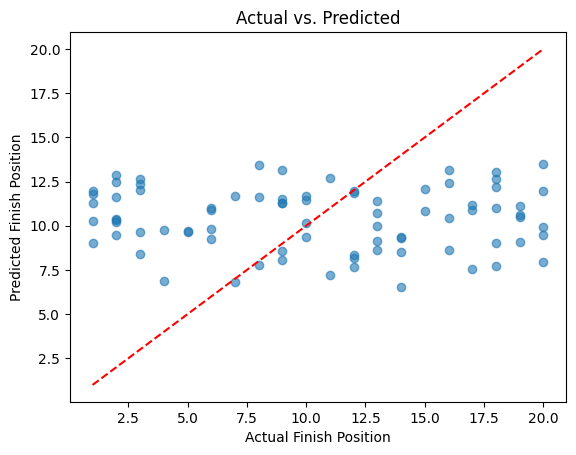

Saved model → snapshot_ranker_model.joblib
Saved scaler → snapshot_scaler.joblib

Dummy Predictions and Ranks:


,driver_id,predicted_finish,predicted_rank
0,DR01,11,2
1,DR02,10,1
2,DR03,10,1


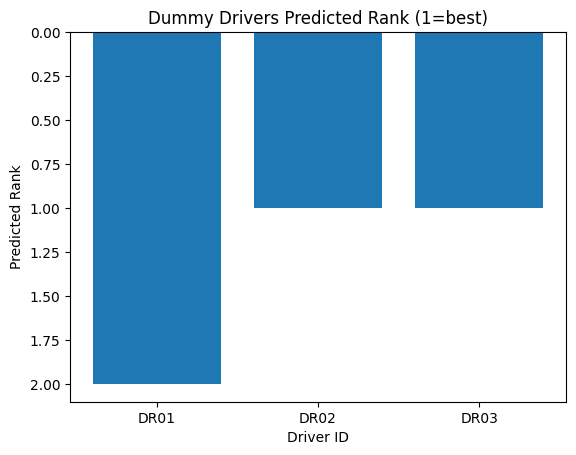

In [16]:
# Paste this entire cell into your Jupyter Notebook and run it

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from IPython.display import display

# 1) Load data from Excel
df = pd.read_excel('race_snapshots.xlsx')

# 2) Select numeric features & target
features = [
    'lap_num', 'current_position', 'best_lap_time', 'avg_lap_time',
    'pit_stops', 'tire_age', 'gap_to_leader',
    'sector1_time', 'sector2_time', 'sector3_time'
]
X = df[features].copy()
# invert best lap time so higher = better
X['inv_lap'] = -X.pop('best_lap_time')
y = df['finishing_position']

# 3) Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 5) Train RandomForest regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# 6) Evaluate
preds = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, preds)
print(f"Hold‑out MAE: {mae:.2f}")

# 7) Plot actual vs predicted
plt.figure()
plt.scatter(y_test, preds, alpha=0.6)
minv, maxv = min(y_test.min(), preds.min()), max(y_test.max(), preds.max())
plt.plot([minv, maxv], [minv, maxv], 'r--')
plt.xlabel('Actual Finish Position')
plt.ylabel('Predicted Finish Position')
plt.title('Actual vs. Predicted')
plt.show()

# 8) Save model and scaler
joblib.dump(model, 'snapshot_ranker_model.joblib')
joblib.dump(scaler, 'snapshot_scaler.joblib')
print("Saved model → snapshot_ranker_model.joblib")
print("Saved scaler → snapshot_scaler.joblib")

# 9) Load artifacts & test with dummy snapshots
loaded_model  = joblib.load('snapshot_ranker_model.joblib')
loaded_scaler = joblib.load('snapshot_scaler.joblib')

dummy = pd.DataFrame([
    {'driver_id':'DR01','lap_num':10,'current_position':9,'best_lap_time':238.0,
     'avg_lap_time':139.5,'pit_stops':1,'tire_age':10,'gap_to_leader':4.0,
     'sector1_time':35.0,'sector2_time':40.0,'sector3_time':55.0},
    {'driver_id':'DR02','lap_num':10,'current_position':4,'best_lap_time':139.2,
     'avg_lap_time':120.8,'pit_stops':1,'tire_age':5,'gap_to_leader':1.2,
     'sector1_time':36.0,'sector2_time':41.0,'sector3_time':54.5},
    {'driver_id':'DR03','lap_num':10,'current_position':2,'best_lap_time':111.0,
     'avg_lap_time':112.5,'pit_stops':0,'tire_age':11,'gap_to_leader':0.5,
     'sector1_time':17.0,'sector2_time':12.0,'sector3_time':26.0},
])

X_d = dummy[features].copy()
X_d['inv_lap'] = -X_d.pop('best_lap_time')
Xd_scaled = loaded_scaler.transform(X_d)
predictions = loaded_model.predict(Xd_scaled)
dummy['predicted_finish'] = np.round(predictions).astype(int)

# Assign predicted rank (1 = best)
dummy['predicted_rank'] = dummy['predicted_finish'].rank(method='dense', ascending=True).astype(int)

print("\nDummy Predictions and Ranks:")
display(dummy[['driver_id','predicted_finish','predicted_rank']])

# 10) Visualize dummy ranking
plt.figure()
plt.bar(dummy['driver_id'], dummy['predicted_rank'])
plt.gca().invert_yaxis()
plt.xlabel('Driver ID')
plt.ylabel('Predicted Rank')
plt.title('Dummy Drivers Predicted Rank (1=best)')
plt.show()


Data shape: (400, 15)


,race_id,lap_num,driver_id,current_position,best_lap_time,avg_lap_time,pit_stops,tire_age,gap_to_leader,weather_flag,sector1_time,sector2_time,sector3_time,finishing_position,win_flag
0,2025-06-01,47,DR01,19,144.387,144.401,0,1,31.486,dry,32.790,35.843,53.664,1,1
1,2025-06-01,25,DR02,14,144.616,145.381,3,9,2.787,dry,43.606,39.010,50.133,18,0
2,2025-06-01,17,DR03,4,138.199,138.394,3,12,26.409,dry,42.200,46.664,51.734,16,0
3,2025-06-01,26,DR04,12,142.842,143.206,3,2,25.509,wet,40.934,33.697,59.696,2,0
4,2025-06-01,24,DR05,13,142.215,142.392,2,12,2.714,wet,46.891,44.946,55.397,9,0


Hold-out MAE: 5.24
Spearman ρ: -0.132


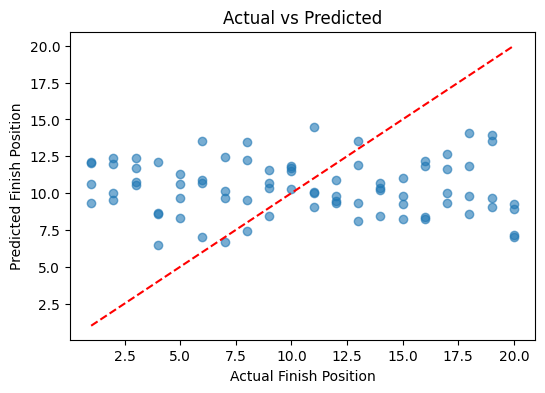

Saved: rf_ranker_improved.joblib, rf_scaler_improved.joblib

Dummy Results:


,driver_id,pred_finish,pred_rank
1,DR02,8,1
2,DR03,9,2
0,DR01,11,3


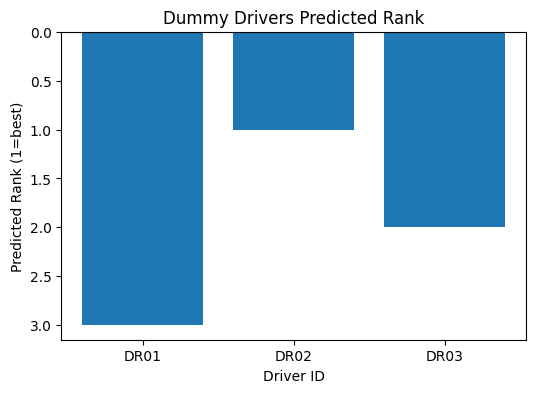

In [30]:
# Paste this into a Jupyter Notebook cell and run (no extra installs needed)

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import display

# 1) Load snapshot data from the correct path
df = pd.read_excel('race_snapshots.xlsx')  # adjust if you moved the file
print("Data shape:", df.shape)
display(df.head())

# 2) Feature engineering: invert everything where lower is better
X = pd.DataFrame({
    'inv_current_pos': -df['current_position'],
    'inv_best_lap':    -df['best_lap_time'],
    'inv_avg_lap':     -df['avg_lap_time'],
    'inv_pit_stops':   -df['pit_stops'],
    'inv_gap':         -df['gap_to_leader'],
    'inv_tire_age':    -df['tire_age'],
    'inv_s1':          -df['sector1_time'],
    'inv_s2':          -df['sector2_time'],
    'inv_s3':          -df['sector3_time'],
})
y = df['finishing_position']

# 3) Group‐wise train/test split by race_id
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df['race_id']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# 4) Scale features
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 5) Train RandomForest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_s, y_train)

# 6) Evaluate
preds = rf.predict(X_test_s)
mae = mean_absolute_error(y_test, preds)
rho, _ = spearmanr(y_test, preds)
print(f"Hold-out MAE: {mae:.2f}")
print(f"Spearman ρ: {rho:.3f}")

# 7) Plot actual vs predicted
plt.figure(figsize=(6,4))
plt.scatter(y_test, preds, alpha=0.6)
mv, Mv = min(y_test.min(), preds.min()), max(y_test.max(), preds.max())
plt.plot([mv, Mv], [mv, Mv], 'r--')
plt.xlabel('Actual Finish Position')
plt.ylabel('Predicted Finish Position')
plt.title('Actual vs Predicted')
plt.show()

# 8) Save model & scaler
joblib.dump(rf, 'rf_ranker_improved.joblib')
joblib.dump(scaler, 'rf_scaler_improved.joblib')
print("Saved: rf_ranker_improved.joblib, rf_scaler_improved.joblib")

# 9) Dummy test (DR03 should win)
dummy = pd.DataFrame([
    {
      'driver_id':       'DR01',
      'current_position': 6,
      'best_lap_time':   140.2,
      'avg_lap_time':    142.0,
      'pit_stops':       2,
      'tire_age':        4,
      'gap_to_leader':   3.5,
      'sector1_time':    36.0,
      'sector2_time':    41.0,
      'sector3_time':    56.0
    },
    {
      'driver_id':       'DR02',
      'current_position': 5,
      'best_lap_time':   139.5,
      'avg_lap_time':    141.0,
      'pit_stops':       1,
      'tire_age':        6,
      'gap_to_leader':   2.0,
      'sector1_time':    35.5,
      'sector2_time':    40.0,
      'sector3_time':    54.0
    },
    {
      'driver_id':       'DR03',
      'current_position': 1,     # leading on track
      'best_lap_time':   136.0,  # fastest best lap
      'avg_lap_time':    137.5,  # lowest average
      'pit_stops':       0,      # no stops
      'tire_age':        6,     # long, consistent stint
      'gap_to_leader':   0.0,    # right at the front
      'sector1_time':    32.0,   # quickest sectors
      'sector2_time':    36.5,
      'sector3_time':    50.0
    },
])
# apply same feature transforms
X_d = pd.DataFrame({
    'inv_current_pos': -dummy['current_position'],
    'inv_best_lap':    -dummy['best_lap_time'],
    'inv_avg_lap':     -dummy['avg_lap_time'],
    'inv_pit_stops':   -dummy['pit_stops'],
    'inv_gap':         -dummy['gap_to_leader'],
    'inv_tire_age':    -dummy['tire_age'],
    'inv_s1':          -dummy['sector1_time'],
    'inv_s2':          -dummy['sector2_time'],
    'inv_s3':          -dummy['sector3_time'],
})
X_d_s = scaler.transform(X_d)
dummy['pred_finish'] = rf.predict(X_d_s).round().astype(int)
dummy['pred_rank'] = dummy['pred_finish'].rank(method='dense').astype(int)

print("\nDummy Results:")
display(dummy[['driver_id','pred_finish','pred_rank']].sort_values('pred_rank'))

# 10) Bar chart of dummy rank
plt.figure(figsize=(6,4))
plt.bar(dummy['driver_id'], dummy['pred_rank'])
plt.gca().invert_yaxis()
plt.xlabel('Driver ID')
plt.ylabel('Predicted Rank (1=best)')
plt.title('Dummy Drivers Predicted Rank')
plt.show()


Data shape: (400, 15)


,race_id,lap_num,driver_id,current_position,best_lap_time,avg_lap_time,pit_stops,tire_age,gap_to_leader,weather_flag,sector1_time,sector2_time,sector3_time,finishing_position,win_flag
0,2025-06-01,47,DR01,19,144.387,144.401,0,1,31.486,dry,32.790,35.843,53.664,1,1
1,2025-06-01,25,DR02,14,144.616,145.381,3,9,2.787,dry,43.606,39.010,50.133,18,0
2,2025-06-01,17,DR03,4,138.199,138.394,3,12,26.409,dry,42.200,46.664,51.734,16,0
3,2025-06-01,26,DR04,12,142.842,143.206,3,2,25.509,wet,40.934,33.697,59.696,2,0
4,2025-06-01,24,DR05,13,142.215,142.392,2,12,2.714,wet,46.891,44.946,55.397,9,0


Hold‐out MAE: 5.24
Spearman ρ: -0.115


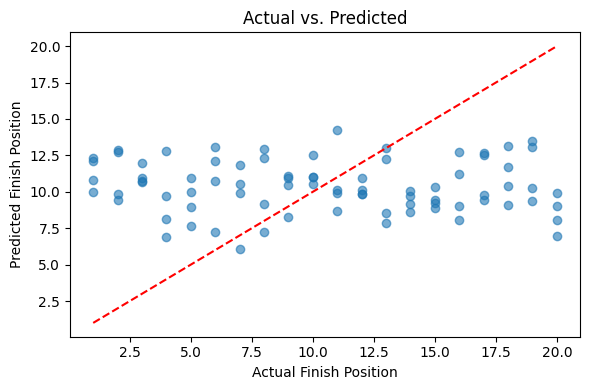

Saved artifacts → rf_ranker_improved.joblib, rf_scaler_improved.joblib

Dummy Predictions with tie-breaker on current_position:


,driver_id,pred_finish,current_position,pred_rank
0,DR03,9,1,1
1,DR02,9,5,2
2,DR01,11,3,3


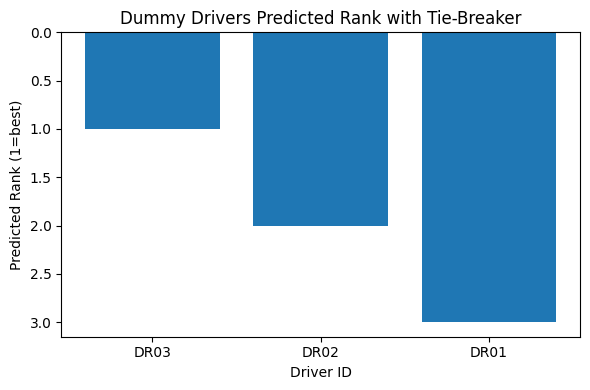

In [38]:
# Paste this entire cell into your Jupyter notebook and run.

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from IPython.display import display

# 1) Load snapshot data
df = pd.read_excel('race_snapshots.xlsx')  # adjust path if needed
print("Data shape:", df.shape)
display(df.head())

# 2) Feature engineering
features = [
    'lap_num','current_position','avg_lap_time',
    'pit_stops','tire_age','gap_to_leader',
    'sector1_time','sector2_time','sector3_time'
]
X = df[features].copy()
X['inv_best_lap'] = -df['best_lap_time']    # invert so higher=better
y = df['finishing_position']

# 3) Group‐wise train/test split by race_id
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df['race_id']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# 4) Scale features
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# 5) Train RandomForest regressor
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train_s, y_train)

# 6) Evaluate on hold‐out set
preds = rf.predict(X_test_s)
mae = mean_absolute_error(y_test, preds)
rho, _ = spearmanr(y_test, preds)
print(f"Hold‐out MAE: {mae:.2f}")
print(f"Spearman ρ: {rho:.3f}")

# 7) Plot actual vs. predicted
plt.figure(figsize=(6,4))
plt.scatter(y_test, preds, alpha=0.6)
vmin, vmax = min(y_test.min(), preds.min()), max(y_test.max(), preds.max())
plt.plot([vmin, vmax],[vmin, vmax], 'r--')
plt.xlabel('Actual Finish Position')
plt.ylabel('Predicted Finish Position')
plt.title('Actual vs. Predicted')
plt.tight_layout()
plt.show()

# 8) Save model & scaler
joblib.dump(rf, 'rf_ranker_improved.joblib')
joblib.dump(scaler, 'rf_scaler_improved.joblib')
print("Saved artifacts → rf_ranker_improved.joblib, rf_scaler_improved.joblib")

# 9) Dummy test with tie-breaker on current_position
dummy = pd.DataFrame([
    {'driver_id':'DR01','lap_num':12,'current_position':3,'best_lap_time':140.2,'avg_lap_time':142.0,
     'pit_stops':2, 'tire_age':4, 'gap_to_leader':3.5, 'sector1_time':36, 'sector2_time':41, 'sector3_time':56},
    {'driver_id':'DR02','lap_num':12,'current_position':5,'best_lap_time':139.5,'avg_lap_time':141.0,
     'pit_stops':1, 'tire_age':6, 'gap_to_leader':2.0, 'sector1_time':35.5, 'sector2_time':40, 'sector3_time':54},
    {'driver_id':'DR03','lap_num':12,'current_position':1,'best_lap_time':136.0,'avg_lap_time':137.5,
     'pit_stops':0, 'tire_age':12, 'gap_to_leader':0.0, 'sector1_time':32, 'sector2_time':37, 'sector3_time':50},
])

# Preprocess dummy features
X_d = dummy[features].copy()
X_d['inv_best_lap'] = -dummy['best_lap_time']
X_d_s = scaler.transform(X_d)

# Predict finishing positions
dummy['pred_finish'] = np.round(rf.predict(X_d_s)).astype(int)

# 10) Tie-break sort by predicted finish, then current_position
dummy = dummy.sort_values(
    by=['pred_finish','current_position'],
    ascending=[True, True]
).reset_index(drop=True)

# 11) Assign sequential ranks 1…N
dummy['pred_rank'] = np.arange(1, len(dummy) + 1)

print("\nDummy Predictions with tie-breaker on current_position:")
display(dummy[['driver_id','pred_finish','current_position','pred_rank']])

# 12) Bar chart of dummy ranks
plt.figure(figsize=(6,4))
plt.bar(dummy['driver_id'], dummy['pred_rank'])
plt.gca().invert_yaxis()  # so rank=1 sits at top
plt.xlabel('Driver ID')
plt.ylabel('Predicted Rank (1=best)')
plt.title('Dummy Drivers Predicted Rank with Tie-Breaker')
plt.tight_layout()
plt.show()
